# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact mlta-2022-spring@googlegroups.com

ref:
 * https://github.com/pai4451/ML2021/blob/main/hw11
 * https://github.com/jnfem112/ML2019FALL/tree/master/final
 * https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af
 * https://github.com/kekmodel/MPL-pytorch
 * https://kelispinor.medium.com/meta-pseudo-label-imagenet-top1-accuracy-90-%E9%81%94%E6%88%90-feb2ed2832a8
 * https://blog.csdn.net/weixin_44005915/article/details/103668481
 

2019FALL 的 ML Final Project
* [NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)
* [NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset

from tqdm.auto import tqdm, trange

In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if cuda else 'cpu')
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device

In [ ]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(3)

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [ ]:
%%script false --no-raise-error

# in colab
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

In [ ]:
# # in colab
# train_path = 'real_or_drawing/train_data'
# test_path = 'real_or_drawing/test_data'

# in kaggle
train_path = '../input/ml2022-spring-hw11/real_or_drawing/train_data'
test_path = '../input/ml2022-spring-hw11/real_or_drawing/test_data'

In [ ]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'{train_path}/{i}/{500*i}.bmp'), title=titles[i])

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'{test_path}/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

In [ ]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']

def edge_show(path, kind):
    plt.figure(figsize=(18, 18))

    original_img = plt.imread(path)
    plt.subplot(1, 5, 1)
    no_axis_show(original_img, title=kind)

    gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
    plt.subplot(1, 5, 2)
    no_axis_show(gray_img, title='gray scale', cmap='gray')

    gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
    plt.subplot(1, 5, 2)
    no_axis_show(gray_img, title='gray scale', cmap='gray')

    canny_50100 = cv2.Canny(gray_img, 50, 100)
    plt.subplot(1, 5, 3)
    no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

    canny_150200 = cv2.Canny(gray_img, 150, 200)
    plt.subplot(1, 5, 4)
    no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

    canny_250300 = cv2.Canny(gray_img, 170, 300) 
    plt.subplot(1, 5, 5)
    no_axis_show(canny_250300, title='Canny(170, 300)', cmap='gray')

for i in range(10):
    edge_show(f'{train_path}/{i}/{500*i+2}.bmp', titles[i])

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [ ]:
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder(train_path, transform=source_transform)
target_dataset = ImageFolder(test_path, transform=target_transform)
test_dataset = ImageFolder(test_path, transform=test_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)  
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
def show(imgs, size_inches=(15, 10)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fig.set_size_inches(*size_inches)
    for i, img in enumerate(imgs):
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()

In [ ]:
def barplot(answers):
    unique, counts = np.unique(answers, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique, titles, rotation='vertical')
    plt.show()

In [ ]:
imgs = iter(source_dataloader).next()[0][:30]
grid = torchvision.utils.make_grid([img.to(device) for img in imgs], nrow=10)
show(grid, size_inches=(15, 5))

imgs = iter(target_dataloader).next()[0][:30]
grid = torchvision.utils.make_grid([img.to(device) for img in imgs], nrow=10)
show(grid, size_inches=(15, 5))

imgs = iter(test_dataloader).next()[0][:30]
grid = torchvision.utils.make_grid([img.to(device) for img in imgs], nrow=10)
show(grid, size_inches=(15, 5))

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

## Dann trained 0.79884

## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

In [ ]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()
        # input (batch, 1, 32, 32)
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 64, 16, 16)

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 128, 8, 8)

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 256, 4, 4)

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 256, 2, 2)

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2) # (batch, 512, 1, 1)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

    
class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c
    
    
class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

### Pre-processing

Here we use Adam as our optimizor.

In [ ]:
feature_extractor_DaNN = FeatureExtractor().to(device)
label_predictor_DaNN = LabelPredictor().to(device)
domain_classifier_DaNN = DomainClassifier().to(device)

feature_extractor_DaNN.load_state_dict(torch.load("../input/hw11tmp/extractor_model.bin", map_location=device))
label_predictor_DaNN.load_state_dict(torch.load("../input/hw11tmp/predictor_model.bin", map_location=device))

In [ ]:
epochs = 2000 # 200 epochs 的 Accuracy 可能會不太穩定，可以多丟幾次或 train 久一點。

# in report learning_rate = 2e-4, weight_decay = 0.0005
learning_rate = 0.001

In [ ]:
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor_DaNN.parameters(), lr=learning_rate)
optimizer_C = optim.Adam(label_predictor_DaNN.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(domain_classifier_DaNN.parameters(), lr=learning_rate)

### Start Training


#### DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

#### Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [ ]:
def lamb_fn(x):
    return 2 * (2 / (1 + np.exp(-10.0/epochs*x)) - 1)

x = np.arange(0, epochs)
y = lamb_fn(x)
plt.plot(x,y)

In [ ]:
def train_epoch(source_dataloader, target_dataloader, epoch, lamb):
    '''
      Args:
        source_dataloader: source data 的 dataloader
        target_dataloader: target data 的 dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier 的 loss
    # F loss: Feature Extractor & Label Predictor 的 loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    
#     progress_bar = tqdm(zip(source_dataloader, target_dataloader))
#     progress_bar.set_description(f"Epoch {epoch+1}")
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).to(device)
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor_DaNN(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier_DaNN(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss += loss.item()
        loss.backward()
        optimizer_D.step()
        
        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor_DaNN(feature[:source_data.shape[0]])
        domain_logits = domain_classifier_DaNN(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss += loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

In [ ]:
%%script false --no-raise-error

feature_extractor_DaNN.train()
label_predictor_DaNN.train()
domain_classifier_DaNN.train()

# train epochs
for epoch in trange(epochs):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, 
                                                        target_dataloader, 
                                                        epoch, 
                                                        lamb=lamb_fn(epoch))

    torch.save(feature_extractor_DaNN.state_dict(), f'extractor_model_DaNN.bin')
    torch.save(label_predictor_DaNN.state_dict(), f'predictor_model_DaNN.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch+1, train_D_loss, train_F_loss, train_acc))

## MCD
https://arxiv.org/pdf/1712.02560.pdf

https://blog.csdn.net/weixin_44005915/article/details/103668481

0.78370(200)

0.79812(400) lr: 0 ~ 200:1e-3, 200 ~ 400:1e-4

0.79200(2000)

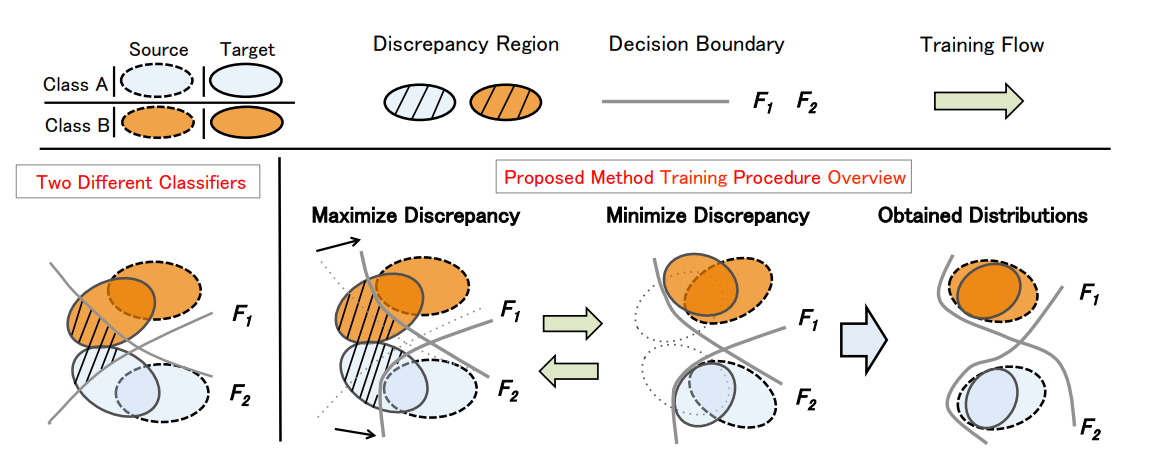

In [ ]:
class LabelPredictor_BNorm(nn.Module):

    def __init__(self):
        super(LabelPredictor_BNorm, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512), # diff with DaNN
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512), # diff with DaNN
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

### Pre-processing

Here we use SGD as our optimizor.

In [ ]:
feature_extractor_MCD = FeatureExtractor().to(device)
label_predictor_1_MCD = LabelPredictor_BNorm().to(device)
label_predictor_2_MCD = LabelPredictor_BNorm().to(device)

# feature_extractor_MCD.load_state_dict(torch.load("../input/hw11tempmcd/extractor_model_MCD.bin", map_location=device))
# label_predictor_1_MCD.load_state_dict(torch.load("../input/hw11tempmcd/predictor1_model_MCD.bin", map_location=device))
# label_predictor_2_MCD.load_state_dict(torch.load("../input/hw11tempmcd/predictor2_model_MCD.bin", map_location=device))

### Hyper-parameter

In [ ]:
epochs = 2000
milestones = [200,1600]
num_k = 4

learning_rate = 1e-3
gamma = 0.1
momentum = 0.9

In [ ]:
def show_plot(total):
    optimizer = torch.optim.SGD(torch.nn.Linear(2, 1).parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    lrs = []

    for i in range(total):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

    plt.plot(range(total), lrs)

    print(lrs[-5:])
    
show_plot(epochs)

In [ ]:
class_criterion = nn.CrossEntropyLoss()

optimizer_F = optim.SGD(feature_extractor_MCD.parameters(), lr=learning_rate, momentum=momentum)
optimizer_C1 = optim.SGD(label_predictor_1_MCD.parameters(), lr=learning_rate, momentum=momentum)
optimizer_C2 = optim.SGD(label_predictor_2_MCD.parameters(), lr=learning_rate, momentum=momentum)

scheduler_F = torch.optim.lr_scheduler.MultiStepLR(optimizer_F, milestones=milestones, gamma=gamma)
scheduler_C1 = torch.optim.lr_scheduler.MultiStepLR(optimizer_C1, milestones=milestones, gamma=gamma)
scheduler_C2 = torch.optim.lr_scheduler.MultiStepLR(optimizer_C2, milestones=milestones, gamma=gamma)

In [ ]:
def discrepancy(output_1 , output_2):
    return torch.mean(torch.abs(F.softmax(output_1 , dim=1) - F.softmax(output_2 , dim=1)))

### Start Training

#### Reminder
* You can refer to [the original work](https://arxiv.org/pdf/1712.02560.pdf).
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [ ]:
def train_epoch(source_dataloader, target_dataloader, epoch, num_k=4, feature_extractor_ref=None, label_predictor_ref=None):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # C loss: Classifier 的 loss
    # F loss: Feature Extractor & Label Predictor 的 loss
    running_FC_loss, running_C_loss, running_F_loss = 0.0, 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    total_hit_ref = 0.0
    
#     progress_bar = tqdm(zip(source_dataloader, target_dataloader))
#     progress_bar.set_description(f"Epoch {epoch+1}")
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.to(device)
        source_label = source_label.to(device)
        target_data = target_data.to(device)
        
        # Step 1 : train all for correct labels
        feature = feature_extractor_MCD(source_data)
        class_logits1 = label_predictor_1_MCD(feature)
        class_logits2 = label_predictor_2_MCD(feature)
        loss = class_criterion(class_logits1, source_label) + class_criterion(class_logits2, source_label)
        running_FC_loss += loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C1.step()
        optimizer_C2.step()
        
        optimizer_F.zero_grad()
        optimizer_C1.zero_grad()
        optimizer_C2.zero_grad()
        
        total_hit += torch.sum(torch.argmax(class_logits1 + class_logits2, dim=1) == source_label).item()
        
        # Step 2 : train label classifier to make more decision boundary
        feature = feature_extractor_MCD(source_data)
        class_logits1 = label_predictor_1_MCD(feature)
        class_logits2 = label_predictor_2_MCD(feature)
        loss_1 = class_criterion(class_logits1, source_label) + class_criterion(class_logits2, source_label)
        feature = feature_extractor_MCD(target_data)
        class_logits1 = label_predictor_1_MCD(feature)
        class_logits2 = label_predictor_2_MCD(feature)
        loss_2 = discrepancy(class_logits1, class_logits2)
        loss = loss_1 - loss_2
        running_C_loss += loss.item()
        loss.backward()
        optimizer_C1.step()
        optimizer_C2.step()
        
        optimizer_F.zero_grad()
        optimizer_C1.zero_grad()
        optimizer_C2.zero_grad()

        # Step 3 : train feature extractor to make less decision boundary
        for k in range(num_k):
            feature = feature_extractor_MCD(target_data)
            class_logits1 = label_predictor_1_MCD(feature)
            class_logits2 = label_predictor_2_MCD(feature)
            loss = discrepancy(class_logits1 , class_logits2)
            running_F_loss += loss.item()
            loss.backward()
            optimizer_F.step()
        
            optimizer_F.zero_grad()
            optimizer_C1.zero_grad()
            optimizer_C2.zero_grad()
        
        if label_predictor_ref:
            class_logits_ref = label_predictor_ref(feature_extractor_ref(target_data))
            total_hit_ref += torch.sum(torch.argmax(class_logits1 + class_logits2, dim=1) == torch.argmax(class_logits_ref, dim=1)).item()

        total_num += source_data.shape[0]

    return running_FC_loss / (i+1), running_C_loss / (i+1), running_F_loss / ((i+1)*num_k), total_hit / total_num, total_hit_ref / total_num

In [ ]:
# %%script false --no-raise-error

feature_extractor_MCD.train()
label_predictor_1_MCD.train()
label_predictor_2_MCD.train()

# train epochs
for epoch in trange(epochs):
    train_FC_loss, train_C_loss, train_F_loss, train_acc, ref_acc = train_epoch(source_dataloader, 
                                                                       target_dataloader, 
                                                                       epoch,
                                                                       num_k,
                                                                       feature_extractor_DaNN,
                                                                       label_predictor_DaNN)

    torch.save(feature_extractor_MCD.state_dict(), f'extractor_model_MCD.bin')
    torch.save(label_predictor_1_MCD.state_dict(), f'predictor1_model_MCD.bin')
    torch.save(label_predictor_2_MCD.state_dict(), f'predictor2_model_MCD.bin')
    
    scheduler_F.step()
    scheduler_C1.step()
    scheduler_C2.step()

    print(f'epoch {epoch+1:>3d}: train FC loss: {train_FC_loss:6.4f}, train C loss: {train_C_loss:6.4f}, train F loss: {train_F_loss:6.4f}, acc {train_acc:6.4f}, ref_acc {ref_acc:6.4f}')

In [ ]:
class Combined_model(nn.Module):
    def __init__(self, modelA, modelB):
        super(Combined_model, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
    def forward(self, x):
        return (F.softmax(self.modelA(x), dim=1) + F.softmax(self.modelB(x), dim=1))/2.0

label_predictor_MCD = Combined_model(label_predictor_1_MCD, label_predictor_2_MCD)

## Ensemble DaNN & MCD

In [ ]:
class Ensemble_Extractor_model(nn.Module):
    def __init__(self, modelA, modelB):
        super(Ensemble_Extractor_model, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
    def forward(self, x):
        return self.modelA(x), self.modelB(x)
    
class Ensemble_Predictor_model(nn.Module):
    def __init__(self, modelA, modelB):
        super(Ensemble_Predictor_model, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
    def forward(self, x):
        return (F.softmax(self.modelA(x[0]), dim=1) + F.softmax(self.modelB(x[1]), dim=1))/2.0
    
feature_extractor_ensemble = Ensemble_Extractor_model(feature_extractor_DaNN, feature_extractor_MCD)
label_predictor_ensemble = Ensemble_Predictor_model(label_predictor_DaNN, label_predictor_MCD)

In [ ]:
class Ensemble_Predictor_model(nn.Module):
    def __init__(self, modelA, modelB):
        super(Ensemble_Predictor_model, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        
    def forward(self, x):
        return self.modelA(x[0]) + self.modelB(x[1])
    
label_predictor_ensemble_plus = Ensemble_Predictor_model(label_predictor_DaNN, label_predictor_MCD)

# Inference

We use pandas to generate our csv file.

In [ ]:
def gen_csv(feature_extractor, label_predictor, file_postfix, do_softmax=True):
    imgs = []
    probs = []
    answers = []
    label_predictor.eval()
    feature_extractor.eval()
    
    sm = torch.nn.Softmax(dim=1)
    for i, (test_data, _) in enumerate(tqdm(test_dataloader)):
        test_data = test_data.to(device)

        class_logits = label_predictor(feature_extractor(test_data))
        if do_softmax:
            class_logits = sm(class_logits)

        prob, x = torch.max(class_logits, dim=1)

        answers.append(x.cpu().detach().numpy())
        imgs.append(test_data.cpu().detach().numpy())
        probs.append(prob.cpu().detach().numpy())

    answers = np.concatenate(answers)
    imgs = np.concatenate(imgs)
    probs = np.concatenate(probs)

    # Generate your submission
    df = pd.DataFrame({'id': np.arange(0,len(answers)), 'label': answers})
    df.to_csv(f"submission_{file_postfix}.csv", index=False)
    
    return answers, probs, imgs

In [ ]:
def show_target_imgs(answers, probs, imgs):
    maps = {i:[] for i in range(10)}
    for i, prob, img in zip(answers, probs, imgs):
        maps[i].append((prob, img))
    
    for i in range(10):
        maps[i].sort(key = lambda x: x[0], reverse = True)

    for i in range(10):
        print(f"{i}: {titles[i]}")
        if maps.get(i):
            train_grid = torchvision.utils.make_grid([FloatTensor(img).to(device) for _, img in maps[i][:30]], nrow=10)
            show(train_grid, size_inches=(15, 5))
        else:
            print("No data")
    
    return maps

## DaNN

In [ ]:
answers_DaNN, probs_DaNN, imgs_DaNN = gen_csv(feature_extractor_DaNN, label_predictor_DaNN, 'DaNN')

barplot(answers_DaNN)
        
maps_DaNN = show_target_imgs(answers_DaNN, probs_DaNN, imgs_DaNN)

## MCD

In [ ]:
answers_MCD, probs_MCD, imgs_MCD = gen_csv(feature_extractor_MCD, label_predictor_MCD, 'MCD')

barplot(answers_MCD)
        
maps_MCD = show_target_imgs(answers_MCD, probs_MCD, imgs_MCD)

## Ensemble

In [ ]:
# 0.79648
answers_ensemble, probs_ensemble, imgs_ensemble = gen_csv(feature_extractor_ensemble, 
                                                          label_predictor_ensemble, 
                                                          'ensemble',
                                                          do_softmax=False)

barplot(answers_ensemble)
        
maps_ensemble = show_target_imgs(answers_ensemble, probs_ensemble, imgs_ensemble)

In [ ]:
# 0.79878
answers_ensemble_plus, probs_ensemble_plus, imgs_ensemble_plus = gen_csv(feature_extractor_ensemble, 
                                                          label_predictor_ensemble_plus, 
                                                          'ensemble_plus',
                                                          do_softmax=True)

barplot(answers_ensemble_plus)
        
maps_ensemble_plus = show_target_imgs(answers_ensemble_plus, probs_ensemble_plus, imgs_ensemble_plus)

## Pseudo Labeling

In [ ]:
class CustomDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, labels, dataset):
        self.labels = labels
        self.dataset = dataset
        
    def __getitem__(self, index):
        label = self.labels[index]
        img, _ = self.dataset.__getitem__(index)
        
        return img, label

    def __len__(self):
        return len(self.labels)

def new_pseudo_dataloader(answers, batch_size=32):
    indices = []
    result = []
    for i, x in enumerate(zip(*answers)):
        if (np.array(x) == x[0]).all():
            indices.append(i)
            result.append(x[0])

    pseudo_dataset = CustomDataset(answers[0], target_dataset)
    pseudo_dataset = Subset(pseudo_dataset, indices)
    pseudo_dataloader = DataLoader(pseudo_dataset, shuffle=True, batch_size=batch_size)
    
    return pseudo_dataloader, result

In [ ]:
pseudo_dataloader, pseudo_answers = new_pseudo_dataloader([answers_DaNN, answers_MCD])
barplot(pseudo_answers)
len(pseudo_dataloader)

In [ ]:
data = iter(pseudo_dataloader).next()
imgs = data[0][:20]
labels = data[1][:20]
grid = torchvision.utils.make_grid([img.to(device) for img in imgs], nrow=10)
show(grid, size_inches=(15, 5))
print([titles[label] for label in labels])

In [ ]:
def pseudo_train(feature_extractor, optimizer_F, label_predictor, optimizer_C, epochs, filename_posfix, train_F):
    label_predictor.train()
    if train_F:
        feature_extractor.train()
    else:
        feature_extractor.eval()

    for epoch in range(epochs):
        running_loss = 0.0
        total_hit, total_num = 0.0, 0.0
        
        progress_bar = tqdm(pseudo_dataloader)
        progress_bar.set_description(f"Epoch {epoch+1}")
        for (i, (img, label)) in enumerate(progress_bar):
            img = img.to(device)
            label = label.to(device)

            feature = feature_extractor(img)
            class_logits = label_predictor(feature)
            loss = class_criterion(class_logits, label)
            running_loss += loss.item()
            loss.backward()
            optimizer_C.step()
            optimizer_C.zero_grad()

            if train_F:
                optimizer_F.step()
                optimizer_F.zero_grad()
            
            
            total_hit += torch.sum(torch.argmax(class_logits, dim=1) == label).item()
            total_num += feature.shape[0]
            
            progress_bar.set_postfix(loss=running_loss/(i+1) ,acc=total_hit / total_num)

    torch.save(label_predictor.state_dict(), f'predictor_model_{filename_posfix}.bin')
    if train_F:
        torch.save(feature_extractor.state_dict(), f'extractor_model_{filename_posfix}.bin')

## New label predictor => bad in DaNN 
0.80016(10 epochs)

In [ ]:
%%script false --no-raise-error

new_label_predictor = LabelPredictor().to(device)
new_optimizer_C = optim.Adam(new_label_predictor.parameters(), lr=0.001)

pseudo_train(feature_extractor_DaNN,
             None,
             new_label_predictor, 
             new_optimizer_C,
             10,
             "pseudo_old_extractor_new_predictor",
             False)

answers, probs, imgs = gen_csv(feature_extractor, 
                           new_label_predictor, 
                           'pseudo_old_extractor_new_predictor')

barplot(answers)

show_target_imgs(answers, probs, imgs)

## New Classifier => best in DaNN
0.81092(10 epochs) => 0.82192(40 epochs) => 0.81622(200 epochs)

MCD(400) & DaNN(2000) => 0.83076(40 epochs)

MCD(2000) & DaNN(2000) => 0.83132 

In [ ]:
new_feature_extractor = FeatureExtractor().to(device)
new_label_predictor = LabelPredictor_BNorm().to(device)

new_optimizer_F = optim.Adam(new_feature_extractor.parameters(), lr=0.001)
new_optimizer_C = optim.Adam(new_label_predictor.parameters(), lr=0.001)

pseudo_train(new_feature_extractor,
             new_optimizer_F,
             new_label_predictor, 
             new_optimizer_C,
             40,
             "pseudo_new_extractor_new_predictor",
             True)

answers, probs, imgs = gen_csv(new_feature_extractor, 
                           new_label_predictor, 
                           'pseudo_new_extractor_new_predictor')

barplot(answers)

show_target_imgs(answers, probs, imgs)

## AutoEncoder for feature => normal in DaNN
0.79404(3 epochs) => 0.81420(5 epochs) => 0.81008(10 epochs) => 0.80790(40 epochs)

In [ ]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        
        # input (batch, 1, 32, 32)
        self.encoder = nn.Sequential(                  
            nn.Conv2d(1, 64, 3, 1, 1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 64, 16, 16)

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 128, 8, 8)

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 256, 4, 4)

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2), # (batch, 256, 2, 2)

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2) # (batch, 512, 1, 1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 512, 2, stride=2, padding=0),  # (batch, 512, 2, 2)
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),  # (batch, 256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  # (batch, 128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),   # (batch, 64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1),    # (batch, 1, 32, 32)
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
autoencoder = conv_autoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(autoencoder.parameters())

In [ ]:
%%script false --no-raise-error

autoencoder.train()
best_loss = np.inf
for epoch in range(100):
    tot_loss = 0.0
    progress_bar = tqdm(target_dataloader)
    progress_bar.set_description(f"Epoch {epoch+1}")
    for i, (data, _) in enumerate(progress_bar):
        # ===================loading=====================
        img = data.to(device)

        # ===================forward=====================
        output = autoencoder(img)
        loss = criterion(output, img)

        tot_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # ===================log========================
        progress_bar.set_postfix(cur_loss=loss.item())
        
    # ===================save_best====================
    mean_loss = tot_loss/(i+1)
    if mean_loss < best_loss:
        print(f"epoch: {epoch + 1:3d}, best loss: {mean_loss:.4f}")
        ori = torchvision.utils.make_grid([x for x in img[:5]], nrow=5) 
        rec = torchvision.utils.make_grid([x for x in output[:5]], nrow=5)
        
        show(ori, size_inches=(10, 3))
        show(rec, size_inches=(10, 3))
        
        best_loss = mean_loss
    # ===================log========================
    print(f"epoch: {epoch + 1:3d}, loss: {mean_loss:.4f}")
    # ===================save_last========================
    torch.save(autoencoder.state_dict(), 'autoencoder_model.bin')

In [ ]:
class Modified_model(nn.Module):
    def __init__(self, model):
        super(Modified_model, self).__init__()
        self.model = model
        
    def forward(self, x):
        return self.model(x).squeeze()
    
autoencoder_feature_extractor = Modified_model(autoencoder.encoder)

In [ ]:
%%script false --no-raise-error

autoencoder_feature_extractor.eval()
autoencoder_label_predictor = LabelPredictor().to(device)

autoencoder_optimizer_C = optim.Adam(autoencoder_label_predictor.parameters(), lr=0.001)

pseudo_train(autoencoder_feature_extractor,
             None,
             autoencoder_label_predictor, 
             autoencoder_optimizer_C,
             10,
             "pseudo_encoder_new_predictor",
             False)

answers, probs, imgs = gen_csv(autoencoder_feature_extractor, 
                               autoencoder_label_predictor, 
                               'pseudo_encoder_new_predictor')

barplot(answers)

show_target_imgs(answers, probs, imgs)

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features
## Step2: Apply t-SNE and normalize
## Step3: Visualization with matplotlib

In [ ]:
# Normalization the processed features 
def norm_(X_tsne):
    x_min, x_max = X_tsne.min(0), X_tsne.max(0)
    X_norm = (X_tsne - x_min) / (x_max - x_min)
    return X_norm

# The shape of X_norm is (N,2)
def plot_tse(X_norm, labels):
    plt.figure(figsize=(8, 8))
    for i in range(X_norm.shape[0]):
        plt.text(X_norm[i, 0], X_norm[i, 1], str(labels[i]), color=plt.cm.Set1(labels[i]), 
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])

def Visualization(feature_extractor, label_predictor):
    # Step1: Load checkpoint and evaluate to get extracted features
    features_source = []
    labels_source = []
    features_target = []
    labels_target = []

    label_predictor.eval()
    feature_extractor.eval()
    for i, (data, label) in enumerate(tqdm(source_dataloader)):
        data = data.to(device)

        feature = feature_extractor(data)

        features_source.append(feature.cpu().detach().numpy())
        labels_source.append(label)

    random_dataloader = DataLoader(target_dataset, batch_size=50, shuffle=True)
    for i, (data, _) in enumerate(tqdm(random_dataloader)):
        if i >= 100:
            break
        data = data.to(device)

        feature = feature_extractor(data)
        class_logits = label_predictor(feature)
        label = torch.argmax(class_logits, dim=1).cpu().detach().numpy()

        features_target.append(feature.cpu().detach().numpy())
        labels_target.append(label)

    features_source = np.concatenate(features_source)
    labels_source = np.concatenate(labels_source)
    features_target = np.concatenate(features_target)
    labels_target = np.concatenate(labels_target)
    
    ## Step2: Apply t-SNE and normalize
    # process extracted features with t-SNE
    X_tsne_source = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1, learning_rate="auto").fit_transform(features_source)
    X_norm_source = norm_(X_tsne_source)

    X_tsne_target = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1, learning_rate="auto").fit_transform(features_target)
    X_norm_target = norm_(X_tsne_target)

    features_cmp = np.concatenate([features_source, features_target])
    labels_cmp = np.concatenate([np.zeros(len(labels_source), dtype=int), np.ones(len(labels_target), dtype=int)])
    X_tsne_cmp = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1, learning_rate="auto").fit_transform(features_cmp)
    X_norm_cmp = norm_(X_tsne_cmp)
    
    ## Step3: Visualization with matplotlib
    # Data Visualization
    plot_tse(X_norm_source, labels_source)
    plot_tse(X_norm_target, labels_target)
    plot_tse(X_norm_cmp, labels_cmp)
    
    # Alternative pandas plot
    df = pd.DataFrame(dict(Feature_1=X_norm_source[:,0], Feature_2=X_norm_source[:,1], label=labels_source))
    df.plot(x="Feature_1", y="Feature_2", kind='scatter', c='label', colormap='viridis')
    
    plt.show()

## DaNN

In [ ]:
# Visualization(feature_extractor_DaNN, label_predictor_DaNN)

## MCD

In [ ]:
# Visualization(feature_extractor_MCD, label_predictor_MCD)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08901058@ntu.edu.tw / mlta-2022-spring@googlegroups.com。

